In [1]:
from google.colab import drive
drive.mount("/content/gdrive")
%cd /content/gdrive/MyDrive/Colab Notebooks/01 - Machine Learning/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/01 - Machine Learning


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt, log
import scipy.sparse as sp
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from matplotlib import rcParams
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10,4)})
rcParams['figure.figsize'] = 10,4

# Recomender System

## Basic

In [4]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/u.data', sep='\t', names=column_names)
movie_titles = pd.read_csv("./data/Movie_Id_Titles")
df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [5]:
moviemat = df.pivot_table(index='user_id',columns='title',values='rating')
moviemat.head()

title,'Til There Was You (1997),1-900 (1994),101 Dalmatians (1996),12 Angry Men (1957),187 (1997),2 Days in the Valley (1996),"20,000 Leagues Under the Sea (1954)",2001: A Space Odyssey (1968),3 Ninjas: High Noon At Mega Mountain (1998),"39 Steps, The (1935)",8 1/2 (1963),8 Heads in a Duffel Bag (1997),8 Seconds (1994),A Chef in Love (1996),Above the Rim (1994),Absolute Power (1997),"Abyss, The (1989)",Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Across the Sea of Time (1995),Addams Family Values (1993),Addicted to Love (1997),"Addiction, The (1995)","Adventures of Pinocchio, The (1996)","Adventures of Priscilla, Queen of the Desert, The (1994)","Adventures of Robin Hood, The (1938)","Affair to Remember, An (1957)","African Queen, The (1951)",Afterglow (1997),"Age of Innocence, The (1993)",Aiqing wansui (1994),Air Bud (1997),Air Force One (1997),"Air Up There, The (1994)",Airheads (1994),Akira (1988),Aladdin (1992),Aladdin and the King of Thieves (1996),Alaska (1996),Albino Alligator (1996),...,"Whole Wide World, The (1996)",Widows' Peak (1994),"Wife, The (1995)",Wild America (1997),Wild Bill (1995),"Wild Bunch, The (1969)",Wild Reeds (1994),Wild Things (1998),William Shakespeare's Romeo and Juliet (1996),Willy Wonka and the Chocolate Factory (1971),Window to Paris (1994),Wings of Courage (1995),Wings of Desire (1987),"Wings of the Dove, The (1997)",Winnie the Pooh and the Blustery Day (1968),"Winter Guest, The (1997)",Wishmaster (1997),With Honors (1994),Withnail and I (1987),Witness (1985),"Wizard of Oz, The (1939)",Wolf (1994),"Woman in Question, The (1950)","Women, The (1939)","Wonderful, Horrible Life of Leni Riefenstahl, The (1993)",Wonderland (1997),"Wooden Man's Bride, The (Wu Kui) (1994)","World of Apu, The (Apur Sansar) (1959)","Wrong Trousers, The (1993)",Wyatt Earp (1994),Yankee Zulu (1994),Year of the Horse (1997),You So Crazy (1994),Young Frankenstein (1974),Young Guns (1988),Young Guns II (1990),"Young Poisoner's Handbook, The (1995)",Zeus and Roxanne (1997),unknown,Á köldum klaka (Cold Fever) (1994)
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,2.0,5.0,NaN,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# find correlation
starwars_user_ratings = moviemat['Star Wars (1977)']
liarliar_user_ratings = moviemat['Liar Liar (1997)']

similar_to_starwars = moviemat.corrwith(starwars_user_ratings)
similar_to_liarliar = moviemat.corrwith(liarliar_user_ratings)

In [7]:
corr_starwars = pd.DataFrame(similar_to_starwars,columns=['Correlation'])
corr_starwars.dropna(inplace=True)
corr_starwars.head()

,Correlation
title,
'Til There Was You (1997),0.872872
1-900 (1994),-0.645497
101 Dalmatians (1996),0.211132
12 Angry Men (1957),0.184289
187 (1997),0.027398


In [8]:
corr_starwars.sort_values('Correlation',ascending=False).head(10)

,Correlation
title,
Hollow Reed (1996),1.0
Commandments (1997),1.0
Cosi (1996),1.0
No Escape (1994),1.0
Stripes (1981),1.0
Star Wars (1977),1.0
Man of the Year (1995),1.0
"Beans of Egypt, Maine, The (1994)",1.0
"Old Lady Who Walked in the Sea, The (Vieille qui marchait dans la mer, La) (1991)",1.0


In [9]:
# filtering out movies that have less than 100 reviews
ratings = pd.DataFrame(df.groupby('title')['rating'].mean())
ratings['num of ratings'] = pd.DataFrame(df.groupby('title')['rating'].count())
corr_starwars = corr_starwars.join(ratings['num of ratings'])
corr_starwars.head()

,Correlation,num of ratings
title,,
'Til There Was You (1997),0.872872,9
1-900 (1994),-0.645497,5
101 Dalmatians (1996),0.211132,109
12 Angry Men (1957),0.184289,125
187 (1997),0.027398,41


In [10]:
corr_starwars[corr_starwars['num of ratings']>100].sort_values('Correlation',ascending=False).head()

,Correlation,num of ratings
title,,
Star Wars (1977),1.000000,584
"Empire Strikes Back, The (1980)",0.748353,368
Return of the Jedi (1983),0.672556,507
Raiders of the Lost Ark (1981),0.536117,420
Austin Powers: International Man of Mystery (1997),0.377433,130


## Memory-Based Collaborative Filtering

Two most common types of recommender systems are **Content-Based** and **Collaborative Filtering (CF)**. 

* Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the "wisdom of the crowd" to recommend items. 
* Content-based recommender systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). The algorithm has the ability to do feature learning on its own, which means that it can start to learn for itself what features to use. 

CF can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**. 

In this tutorial, we will implement Model-Based CF by using singular value decomposition (SVD) and Memory-Based CF by computing cosine similarity. 

In [11]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('./data/u.data', sep='\t', names=column_names)

movie_titles = pd.read_csv("./data/Movie_Id_Titles")

df = pd.merge(df,movie_titles,on='item_id')
df.head()

,user_id,item_id,rating,timestamp,title
0,0,50,5,881250949,Star Wars (1977)
1,290,50,5,880473582,Star Wars (1977)
2,79,50,4,891271545,Star Wars (1977)
3,2,50,5,888552084,Star Wars (1977)
4,8,50,5,879362124,Star Wars (1977)


In [12]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print('Num. of Users: '+ str(n_users))
print('Num of Movies: '+ str(n_items))

Num. of Users: 944
Num of Movies: 1682


Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-item filtering** and **item-item filtering**. 

A *user-item filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. It takes items and outputs other items as recommendations. 

* *Item-Item Collaborative Filtering*: “Users who liked this item also liked …”
* *User-Item Collaborative Filtering*: “Users who are similar to you also liked …”

In [15]:
train_data, test_data = train_test_split(df, test_size=0.25)
train_data_matrix = np.zeros((n_users, n_items))
train_data_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

pd.DataFrame(train_data_matrix).tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1642,1643,1644,1645,1646,1647,1648,1649,1650,1651,1652,1653,1654,1655,1656,1657,1658,1659,1660,1661,1662,1663,1664,1665,1666,1667,1668,1669,1670,1671,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,0.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
940,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# use the pairwise_distances function from sklearn to calculate the cosine similarity. 
# the output will range from 0 to 1 since the ratings are all positive.
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')
pd.DataFrame(user_similarity).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,904,905,906,907,908,909,910,911,912,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943
0,0.000000,0.893154,0.982276,0.955604,0.726615,0.690401,0.670452,0.753898,0.983871,0.700345,0.762454,0.777443,0.643984,0.777070,0.874397,0.684143,0.885965,0.666024,0.910969,0.792182,0.870828,0.699747,0.709755,0.798391,0.728440,0.841032,0.903879,0.792115,0.869013,0.893381,0.919672,0.832534,0.975450,0.988769,0.976677,1.000000,0.745711,0.859372,0.929762,0.924220,...,0.970134,0.910410,0.803480,0.787100,0.890235,0.813110,0.812884,0.852861,0.669619,0.948594,0.943196,0.555290,0.939312,0.808794,0.762833,0.961950,0.811895,0.715085,0.888544,0.798212,0.965051,0.916756,0.791716,0.782524,0.768574,0.781827,0.910115,0.726233,0.612125,0.711581,0.914935,0.779755,0.901342,0.855751,0.885208,0.779255,0.949243,0.874137,0.722706,0.925897
1,0.893154,0.000000,0.875031,0.822962,0.958199,0.775461,0.910305,0.938907,0.835184,0.858791,0.890926,0.944499,0.810561,0.875289,0.718990,0.886826,0.796080,0.870726,0.939350,0.954085,0.792346,0.983984,0.881745,0.867645,0.900511,0.556388,0.889875,0.943935,0.794080,0.834140,0.916171,0.803350,0.766696,0.859989,0.909689,0.953342,0.964866,0.935405,0.736837,0.730765,...,0.843341,0.750172,0.775716,0.925029,0.893446,0.783133,0.988720,1.000000,0.851228,0.953579,0.765498,0.906312,0.828270,0.978424,0.726152,0.717462,0.840334,0.964950,0.794884,0.789444,0.965440,0.688107,0.936050,0.953968,0.950701,0.825672,0.612031,0.948954,0.944827,0.853478,0.865583,0.730317,0.690576,0.805894,0.826539,0.763185,0.848023,0.888164,0.920754,1.000000
2,0.982276,0.875031,0.000000,0.703179,0.973447,0.943731,0.961516,0.929694,0.919873,0.949674,0.933638,0.929489,0.846061,0.984284,0.882127,0.931224,0.968387,0.965110,0.935380,0.960139,0.851850,0.997393,0.985217,0.943048,0.953173,0.891261,1.000000,0.970796,0.895421,0.911065,0.806690,0.948292,0.846461,0.913321,0.823593,0.945993,1.000000,0.951237,0.819307,0.692837,...,0.819841,0.966576,0.884532,0.912832,0.951314,0.953635,1.000000,0.968357,0.936326,1.000000,0.700675,0.956364,0.975152,1.000000,0.822790,0.662455,0.899239,0.957303,0.912933,0.951327,0.882988,0.704618,0.960964,0.968994,0.955864,0.982538,0.911970,1.000000,0.953079,0.969472,0.962658,0.862526,0.942809,0.944707,0.985188,0.838099,0.937173,0.873298,0.966402,1.000000
3,0.955604,0.822962,0.703179,0.000000,0.985400,0.969307,0.953803,0.844016,0.930068,1.000000,0.927450,0.974154,0.935466,0.975996,0.830179,0.939975,0.922747,1.000000,0.894725,0.963472,0.922671,0.977702,0.954842,0.963375,0.952319,0.871287,1.000000,0.920705,0.885324,0.831825,0.938866,0.918768,0.700632,0.908698,0.824371,1.000000,0.972049,0.935950,0.790637,0.761165,...,0.838139,0.959160,0.905152,0.968048,1.000000,0.917597,1.000000,1.000000,0.942063,1.000000,0.885477,0.964093,0.981784,1.000000,0.882380,0.913389,0.908151,0.962221,1.000000,0.980176,0.956008,0.842099,0.917326,0.977269,0.980390,0.930656,0.906469,0.987176,0.983876,0.957370,1.000000,0.908377,0.841183,0.891903,0.954754,0.777686,1.000000,0.927042,0.964812,1.000000
4,0.726615,0.958199,0.973447,0.985400,0.000000,0.838229,0.719511,0.785449,0.953283,0.844730,0.773236,0.945422,0.716461,0.813473,0.932655,0.775693,0.919919,0.784937,0.909059,0.812075,0.837252,0.638237,0.733696,0.908883,0.787358,0.859402,0.945454,0.791765,0.951696,0.884375,0.971835,0.846142,1.000000,1.000000,0.996322,1.000000,0.810057,0.781086,1.000000,0.996507,...,1.000000,0.963623,0.914243,0.826294,1.000000,0.856448,0.808982,0.896463,0.730025,0.973135,1.000000,0.740826,0.953841,0.907738,0.866991,1.000000,0.859547,0.741410,0.880375,0.887663,0.979732,1.000000,0.749491,0.960438,0.836246,0.948392,0.965527,0.732647,0.677266,0.756336,0.942193,0.923315,0.923904,0.919962,0.955183,0.870669,0.847920,0.909000,0.752773,0.827734


Next step is to make predictions. You have already created similarity matrices: `user_similarity` and `item_similarity` and therefore you can make a prediction by applying following formula for user-based CF:

You can look at the similarity between users *k* and *a* as weights that are multiplied by the ratings of a similar user *a* (corrected for the average rating of that user). You will need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that you are trying to predict. 

The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. To give an example: suppose, user *k* gives 4 stars to his favourite movies and 3 stars to all other good movies. Suppose now that another user *t* rates movies that he/she likes with 5 stars, and the movies he/she fell asleep over with 3 stars. These two users could have a very similar taste but treat the rating system differently. 

When making a prediction for item-based CF you don't need to correct for users average rating since query user itself is used to do predictions.

In [21]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

In [22]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [27]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.126582818658921
Item-based CF RMSE: 3.4531531062319325


Memory-based algorithms are easy to implement and produce reasonable prediction quality. 
The drawback of memory-based CF is that it doesn't scale to real-world scenarios and doesn't address the well-known cold-start problem, that is when new user or new item enters the system. 

Model-based CF methods are scalable and can deal with higher sparsity level than memory-based models, but also suffer when new users or items that don't have any ratings enter the system. Read [post](http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/) about Memory-Based Collaborative Filtering. 

## Model-based Collaborative Filtering

Model-based Collaborative Filtering is based on **matrix factorization (MF)** which has received greater exposure, mainly as an unsupervised learning method for latent variable decomposition and dimensionality reduction. 

Matrix factorization is widely used for recommender systems where it can deal better with scalability and sparsity than Memory-based CF. The goal of MF is to learn the latent preferences of users and the latent attributes of items from known ratings (learn features that describe the characteristics of ratings) to then predict the unknown ratings through the dot product of the latent features of users and items. 

When you have a very sparse matrix, with a lot of dimensions, by doing matrix factorization you can restructure the  user-item matrix into low-rank structure, and you can represent the matrix by the multiplication of two low-rank matrices, where the rows contain the latent vector. You fit this matrix to approximate your original matrix, as closely as possible, by multiplying the low-rank matrices together, which fills in the entries missing in the original matrix.

### SVD
A well-known matrix factorization method is **Singular value decomposition (SVD)**. Collaborative Filtering can be formulated by approximating a matrix `X` by using singular value decomposition. The winning team at the Netflix Prize competition used SVD matrix factorization models to produce product recommendations, for more information I recommend to read articles: [Netflix Recommendations: Beyond the 5 stars](http://techblog.netflix.com/2012/04/netflix-recommendations-beyond-5-stars.html) and [Netflix Prize and SVD](http://buzzard.ups.edu/courses/2014spring/420projects/math420-UPS-spring-2014-gower-netflix-SVD.pdf).
The general equation can be expressed as follows:
<img src="https://latex.codecogs.com/gif.latex?X=USV^T" title="X=USV^T" />


Given `m x n` matrix `X`:
* *`U`* is an *`(m x r)`* orthogonal matrix
* *`S`* is an *`(r x r)`* diagonal matrix with non-negative real numbers on the diagonal
* *V^T* is an *`(r x n)`* orthogonal matrix

Elements on the diagnoal in `S` are known as *singular values of `X`*. 


Matrix *`X`* can be factorized to *`U`*, *`S`* and *`V`*. The *`U`* matrix represents the feature vectors corresponding to the users in the hidden feature space and the *`V`* matrix represents the feature vectors corresponding to the items in the hidden feature space.

In [ ]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.724906257092239


Carelessly addressing only the relatively few known entries is highly prone to overfitting. SVD can be very slow and computationally expensive. More recent work minimizes the squared error by applying alternating least square or stochastic gradient descent and uses regularization terms to prevent overfitting. Alternating least square and stochastic gradient descent methods for CF will be covered in the next tutorials.

Review:

* **Memory-based models** are based on similarity between items or users, where we use cosine-similarity.
* **Model-based CF** is based on matrix factorization where we use SVD to factorize the matrix.
* Building recommender systems that perform well in cold-start scenarios (where little data is available on new users and items) remains a challenge. The standard collaborative filtering method performs poorly is such settings. 

## Apriori

People bought ... also bought ... like ironman also like captain america

Calculation by finding support, confidence and lift

P (A|B)/P(A) to see how strong is the relation

In [29]:
dataset = pd.read_csv('./data/Market_Basket_Optimisation.csv', header=None)
dataset.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# length decide the minimum item in basket
# can only experimental with different values for parameters
transactions = dataset.values.tolist()
rules = apriori(transactions, min_support = 0.003, min_confidence = 0.2, min_lift = 3, min_length = 2)

# Reinforce Learning

In [ ]:
dataset = pd.read_csv('./data/Ads_CTR_Optimisation.csv')
dataset.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [ ]:
# 10 ads with 10 000 rounds/users
N = 10000
d = dataset.shape[-1]
ads_selected = []
total_reward = 0

In [ ]:
# create vector of size d containing 0
numbers_of_selections = np.zeros(d)
sums_of_rewards = np.zeros(d)

In [ ]:
for n in range(0, N):
    ad = 0
    max_upper_bound = 0
    
    for i in range(0, d):
        if (numbers_of_selections[i] > 0):
        
            # average reward 
            average_reward = sums_of_rewards[i] / numbers_of_selections[i]
            # confidence interval 
            delta_i = sqrt(3/2 * log(n + 1) / numbers_of_selections[i])
            
            # upper bound will be average + interval
            upper_bound = average_reward + delta_i
            
        else:
            upper_bound = 1e400
            
        # choose the max upper round in 10 ads
        if upper_bound > max_upper_bound:
            max_upper_bound = upper_bound
            ad = i 
    ads_selected.append(ad)
    numbers_of_selections[ad] = numbers_of_selections[ad] + 1
    reward = dataset.values[n, ad]
    sums_of_rewards[ad] = sums_of_rewards[ad] + reward
    total_reward = total_reward + reward

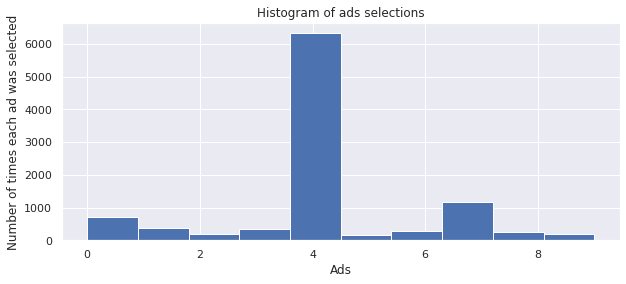

In [ ]:
# Visualising the results
plt.hist(ads_selected)
plt.title('Histogram of ads selections')
plt.xlabel('Ads')
plt.ylabel('Number of times each ad was selected')
plt.show()